In [1]:
from model import power_law_distribution as dist
from model import gt_model as model
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import graph_tool.all as gt

/home/matthias/.virtualenvs/thesis_new/lib/python3.6/site-packages/graph_tool/draw/cairo_draw.py:1480: RuntimeWarning: Error importing Gtk module: No module named 'gi'; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


In [2]:
%matplotlib inline
np.random.seed(42)

# 1. Example

In [3]:
num_users = 500
num_iterations = 5000

inv_cdf = dist.inv_cdf(2.7, 0.001) 
actyivity_potentials = dist.inverse_transform_sampling(inv_cdf)

g, events, features = model.gt_model(num_iterations, num_users, actyivity_potentials, 
                                     p_deletion=5e-05, p_triadic_closure=0.9, 
                                     link_reinforecement_inc=1.0, 
                                     max_peer_influence_prob=0.05, 
                                     peer_influence_thres=0.10,
                                     log_features=True, tqdm=True)

In [4]:
event_log = pd.DataFrame(events, columns=['timestep', 'active user', 'other user', 'peer influenced'])
event_log.head()

,timestep,active user,other user,peer influenced
0,0,412,42,False
1,2,377,277,False
2,4,264,29,False
3,4,335,417,False
4,6,358,340,False


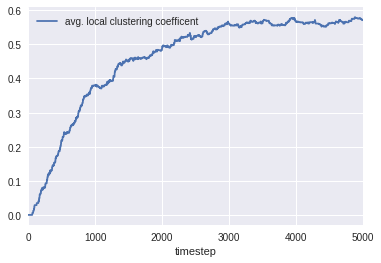

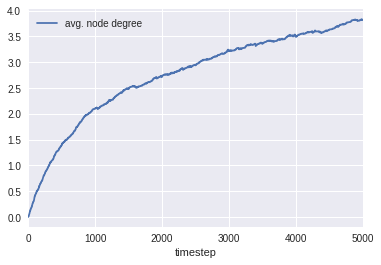

In [5]:
features_log = pd.DataFrame(features, columns=[
        'timestep', 'avg. node degree', 'avg. local clustering coefficent', 
        'avg. weight', '# created links', '# reinforced links'
    ])

features_log['fraction created links'] = features_log['# created links'] / (features_log['# created links'] + features_log['# reinforced links'])
features_log['fraction reinforced links'] = 1.0 - features_log['fraction created links']

features_log.plot(x='timestep', y='avg. local clustering coefficent');
features_log.plot(x='timestep', y='avg. node degree');

In [6]:
# skip time steps with no activity at all
features_log[(features_log['# created links'] > 0) | (features_log['# reinforced links'] > 0)].tail()

,timestep,avg. node degree,avg. local clustering coefficent,avg. weight,# created links,# reinforced links,fraction created links,fraction reinforced links
4993,4993,3.82,0.570962,5.840838,0,1,0.0,1.0
4995,4995,3.82,0.570962,5.842932,0,2,0.0,1.0
4996,4996,3.82,0.570962,5.843979,0,1,0.0,1.0
4998,4998,3.82,0.570962,5.847120,0,3,0.0,1.0
4999,4999,3.82,0.570962,5.849215,0,2,0.0,1.0


# 2. Example

In [6]:
num_users = 1000
num_iterations = 10000

inv_cdf = dist.inv_cdf(2.8, 10**-3) 
actyivity_potentials = dist.inverse_transform_sampling(inv_cdf)

g, _, _ = model.gt_model(num_iterations, num_users, actyivity_potentials, 
                                     p_deletion=0.00005, p_triadic_closure=0.95, 
                                     link_reinforecement_inc=2.0, tqdm=True,
                                     max_peer_influence_prob=0.0, log_features=False)

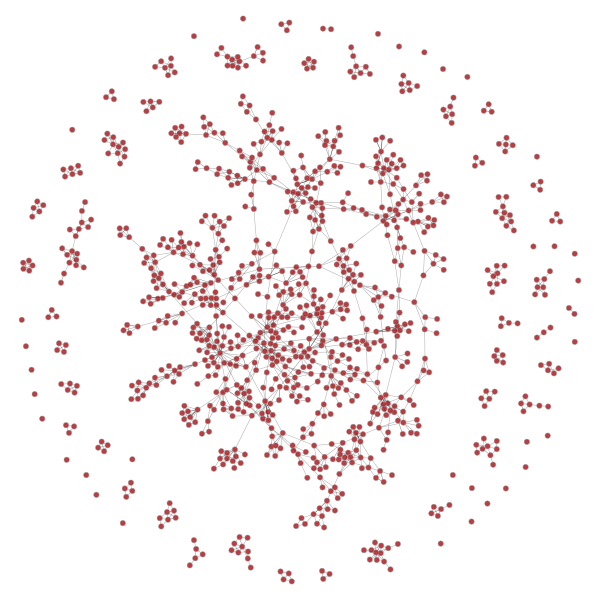

In [7]:
alpha_smoothing = 0.3
edge_colors = g.new_edge_property('vector<double>')
max_weight = max(g.ep.weight)
for edge in g.edges():
    alpha = min((g.ep.weight[edge] / max_weight) + alpha_smoothing, 1.0)
    edge_colors[edge] = [0.0, 0.0, 0.0, alpha]

gt.graph_draw(g, edge_color=edge_colors, inline=True, output_size=(600, 600));